In [5]:
import tensorflow as tf
import numpy as np
import matplotlib
import os

In [6]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [7]:
# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [8]:
# Open, High, Low, Volume, Close
xy = np.loadtxt('data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-1]]  # Close as label

In [9]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

[[  2.13751054e-01   2.08179810e-01   1.91791832e-01   4.66075110e-04
    1.92092403e-01]
 [  1.93935034e-01   2.03641926e-01   2.08664571e-01   2.98467330e-03
    1.96551555e-01]
 [  2.10516454e-01   2.05289413e-01   2.03558748e-01   2.59926504e-04
    1.87749731e-01]
 [  1.86678765e-01   2.09480567e-01   2.08781843e-01   0.00000000e+00
    2.17448151e-01]
 [  3.06973882e-01   3.14634137e-01   2.18993665e-01   1.24764722e-02
    2.16981885e-01]
 [  2.19142110e-01   2.63907214e-01   2.24686396e-01   4.56323384e-01
    2.24967473e-01]
 [  2.33129931e-01   2.36419163e-01   1.62682724e-01   5.70171193e-01
    1.47442742e-01]] -> [ 0.13289962]
[[  1.93935034e-01   2.03641926e-01   2.08664571e-01   2.98467330e-03
    1.96551555e-01]
 [  2.10516454e-01   2.05289413e-01   2.03558748e-01   2.59926504e-04
    1.87749731e-01]
 [  1.86678765e-01   2.09480567e-01   2.08781843e-01   0.00000000e+00
    2.17448151e-01]
 [  3.06973882e-01   3.14634137e-01   2.18993665e-01   1.24764722e-02
    2.169818

In [10]:
# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

In [11]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

In [12]:
# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

In [13]:
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

In [14]:
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

[step: 0] loss: 176.83091735839844
[step: 1] loss: 100.35365295410156
[step: 2] loss: 49.350830078125
[step: 3] loss: 20.789081573486328
[step: 4] loss: 10.353255271911621
[step: 5] loss: 12.35012149810791
[step: 6] loss: 19.651281356811523
[step: 7] loss: 25.808330535888672
[step: 8] loss: 27.80834197998047
[step: 9] loss: 25.79370880126953
[step: 10] loss: 21.251306533813477
[step: 11] loss: 15.800512313842773
[step: 12] loss: 10.694012641906738
[step: 13] loss: 6.694270133972168
[step: 14] loss: 4.112747669219971
[step: 15] loss: 2.9124372005462646
[step: 16] loss: 2.8279666900634766
[step: 17] loss: 3.4796905517578125
[step: 18] loss: 4.468764781951904
[step: 19] loss: 5.4467387199401855
[step: 20] loss: 6.157937526702881
[step: 21] loss: 6.4565534591674805
[step: 22] loss: 6.30318546295166
[step: 23] loss: 5.747203826904297
[step: 24] loss: 4.901044845581055
[step: 25] loss: 3.911405563354492
[step: 26] loss: 2.9308581352233887
[step: 27] loss: 2.0926403999328613
[step: 28] loss: 

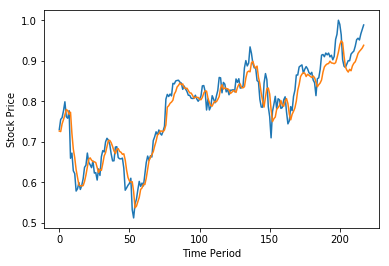

In [15]:
# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()